<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/%5BFeature_Densities%5D_CERN_uncertainties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

1.   Download Rich detector dataset (from GDrive)
2.   Download [Uncertainty code](https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git) from [paper]().
3.   Install dependencies.



In [1]:
import numpy
!python --version
!pip install tf_keras

Python 3.10.13


In [2]:
IN_COLAB = True

try:
    import google.colab
    from google.colab import drive

    drive.mount('/content/drive')
    !ls '/content/drive/MyDrive/data/rich'
    !git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
    !mv lhcb-rich-gan-uncertainty/experiments .
    !mv lhcb-rich-gan-uncertainty/src .
    !rm -r lhcb-rich-gan-uncertainty/
    !rm -r sample_data/
    !pip install tensorflow-addons
except:
    IN_COLAB = False

In [6]:
import os
import numpy as np
import tensorflow as tf
import tf_keras

from experiments.efficiency.uncertainty_model_train import train_model
from experiments.efficiency.uncertainty_models import uncertainty_mlp
from experiments.efficiency.uncertainty_utils import (
    efficiency_bands_with_uncertainty, efficiency_momentum_with_uncertainty)
from experiments.efficiency.utils import (
    efficiency_bands, efficiency_momentum, ensemble_and_ref_model_inference,
    ensemble_and_ref_model_inference_on_bands, tf_to_numpy_dataset,
    threshold_selection)
from src.cramer_gan_trainer import CramerGANTrainer
from src.dataset import CramerGANDataset
from src.datasets.utils_rich import (get_merged_typed_dataset,
                                     parse_dataset_np, parse_example)
from src.models.gans.discriminators.fcn_disc import RICHDiscriminator
from src.models.gans.generators.fcn_gen import RichMCDropFunc, VirtualEnsembleModel

print(f'GPU available? {tf.config.list_physical_devices("GPU")}')

C:\Users\esteb\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# GLOBALS
PARTICLES = ["pion", 'kaon', "muon", "proton"]
# DROPOUTS = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
DROPOUTS = [0.25, 0.3, 0.35, 0.4]
ENSEMBLES = [16, 32, 64, 128, 256]
NUM_REPS = 10
SUB_SAMPLE_SIZE = .3
THRESHOLD = 1.0

DATA_DIR = '/content/drive/MyDrive/data/rich' if IN_COLAB else '../data/rich'
CHECKPOINT_BASE = '/content/drive/MyDrive/Documentos/Maestria ITCR/cern/checkpoints/' if IN_COLAB else '../checkpoints'
CKPT_NUMBER = 'ckpt-21'


def get_checkpoint_name(particle):
    return f'bernoulli_structured_dropout_line_test_cramer_weighted_{particle}'

# Particle selection and dataset split

 Line experiment is mainly focused on testing whether the ensemble-based uncertainty is applicable for out-of-distribution data. To check this, we make train/test split as two disjoint sets. Taking the symmetry of the data after standardization, we split the data by the line $y=x$ (we consider pseudorapidity (ETA) and momentum (P) for split).

 ------
 Notes


*   Data is split based on two dimensions arbitrarily (P abd ETA)
*   Data is scaled to follow a normal distribution



- Features
  - Brunel_P
  - Brunel_ETA
  - nTracks_Brunel

- Targets:
    - RichDLLe
    - RichDLLk
    - RichDLLmu
    - RichDLLp
    - RichDLLbt

- Discarded
  - probe_sWeight

In [8]:
def _split_by_line(df, slope=1, intercept=0):
    top_half = df[df['Brunel_ETA'] > df['Brunel_P'] * slope + intercept]
    bottom_half = df[df['Brunel_ETA'] <= df['Brunel_P'] * slope + intercept]

    top_half = top_half.reset_index(drop=True)
    bottom_half = bottom_half.reset_index(drop=True)

    return top_half, bottom_half


def split_by_line(df_train, df_test):
    return _split_by_line(df_train)[0], _split_by_line(df_test)[1]


def load_particle_datasets(particle, data_dir=DATA_DIR):
    """ The returned dictionary has this format:
        {
          "<particle_name>": {
            'data_train': data_train,
            'data_val': data_val,
            'scaler': scaler,
            'feats_train': feats_train,
            'targets_train': targets_train,
            'feats_val': feats_val,
            'targets_val': targets_val
          }
        }
    """
    data_train, data_val, scaler = get_merged_typed_dataset(data_dir, particle, dtype=np.float32, log=True,
                                                            sample_fn=split_by_line)
    feats_train, targets_train, _ = parse_dataset_np(data_train)
    feats_val, targets_val, _ = parse_dataset_np(data_val)

    print(f'feats_train shape\t{feats_train.shape}\n'
          f'targets_train shape\t{targets_train.shape}\n'
          f'feats_val shape  \t{feats_val.shape}\n'
          f'targets_val shape\t{targets_val.shape}\n')

    return {
        'data_train': data_train,
        'data_val': data_val,
        'scaler': scaler,
        'feats_train': feats_train,
        'targets_train': targets_train,
        'feats_val': feats_val,
        'targets_val': targets_val
    }


datasets = {particle: load_particle_datasets(particle) for particle in PARTICLES}

Reading and concatenating datasets:
	../data/rich\pion2_+_down_2016_.csv
	../data/rich\pion2_+_up_2016_.csv
	../data/rich\pion2_-_down_2016_.csv
	../data/rich\pion2_-_up_2016_.csv
	../data/rich\pion_+_down_2016_.csv
	../data/rich\pion_+_up_2016_.csv
	../data/rich\pion_-_down_2016_.csv
	../data/rich\pion_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.271998643875122
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948325, 3)
targets_train shape	(948325, 5)
feats_val shape  	(527302, 3)
targets_val shape	(527302, 5)

Reading and concatenating datasets:
	../data/rich\kaon2_+_down_2016_.csv
	../data/rich\kaon2_+_up_2016_.csv
	../data/rich\kaon2_-_down_2016_.csv
	../data/rich\kaon2_-_up_2016_.csv
	../data/rich\kaon_+_down_2016_.csv
	../data/rich\kaon_+_up_2016_.csv
	../data/rich\kaon_-_down_2016_.csv
	../data/rich\kaon_-_up_2016_.csv
splitting to train/val/t

# Models creation (restoring from checkpoint)

 This chapter contains the only model definition and restores the model from the checkpoint. It does not contain training/evaluation routines since it was done in another notebook (look LineTestTrain.ipynb notebook).

We use Cramer GAN modification to train generator learn the distribution. [Link](https://arxiv.org/abs/1705.10743) to Cramer GAN for more details. The training configuration:

* Batch size: 1000
* Critic steps: 15
* Generator optimizer: RMSProp with learning rate 0.0002
* iscriminator optimizer: RMSProp with learning rate 0.0002
* Use weights: True
* Number of epochs: 400

In [9]:
class MonteCarloDroupoutModel:
    def __init__(self, particle, dropout_rate,
                 log_dir='log_dir_tmp',
                 checkpoint_base=CHECKPOINT_BASE,
                 chekpoint_file=CKPT_NUMBER,
                 debug=False):
        self.particle = particle
        self.dropout_rate = dropout_rate
        self.log_dir = log_dir

        print(f'Generating model for {particle} with a dropout rate of {dropout_rate}')

        self._gen_config = {
            'drop_rate': dropout_rate,
            # 'dropout_type': 'bernoulli_structured',
            'dropout_type': 'bernoulli',
            # 'drop_kwargs': {'patch_size': 3}
        }

        self._generator = RichMCDropFunc(**self._gen_config)
        self._generator.build((None, 3))
        self._discriminator = RICHDiscriminator()

        self._checkpoint_dir = os.path.join(checkpoint_base, get_checkpoint_name(self.particle))
        self._filename = os.path.join(self._checkpoint_dir, chekpoint_file)

        if debug:
            print("\nGenerator:\n")
            print(self._generator.summary(line_length=96))
            print("\nDiscriminator:\n")
            print(self._discriminator.summary())
            print(f"\nCheckpoint filename: {self._filename}\n")

        # Model was trained with tensorflow 2.10.1, use the legacy optimizer
        self._generator_optimizer = tf_keras.optimizers.legacy.RMSprop(2e-4)
        self._discriminator_optimizer = tf_keras.optimizers.legacy.RMSprop(2e-4)

        self._trainer_config = {
            'generator': self._generator,
            'discriminator': self._discriminator,
            'generator_optimizer': self._generator_optimizer,
            'discriminator_optimizer': self._discriminator_optimizer,
            'checkpoint_dir': self._checkpoint_dir,
            'log_dir': log_dir
        }
        trainer = CramerGANTrainer(**self._trainer_config)
        # Restore pretrained model
        trainer.restore(self._filename)

    def __str__(self):
        return f"{self.particle}_{self.dropout_rate}"

    def get_generator(self) -> VirtualEnsembleModel:
        return self._generator

# Test model creation
#mc_model = MonteCarloDroupoutModel('kaon', 0.1, debug=True)


In [10]:
mc_model = MonteCarloDroupoutModel('kaon', 0.1, debug=True)
gen1 = mc_model.get_generator()
gen1.single_model_inference_mode()
gen1.summary()

Generating model for kaon with a dropout rate of 0.1
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0    

In [11]:
input_data = np.random.rand(1, 3)
input_data

array([[0.25103041, 0.49043669, 0.00187302]])

In [12]:
gen1.predict(input_data)

1/1 [==============================] - 3s 3s/step


array([[0.3100981 , 0.20763627, 0.978038  , 0.49681485, 0.57436204]],
      dtype=float32)

In [13]:
len(gen1.layers)

18

In [14]:
from keras_models import Model

XX = gen1.input
# YY = gen1.layers[14].output
YY = tf_keras.layers.Dense(128)(gen1.get_layer("Layer_1/Dense").output)
new_model = Model(XX, YY)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 3)]               0         
                                                                 
 NoiseInjection (NoiseInject  (None, 67)               0         
 ion)                                                            
                                                                 
 Layer_0/Dense (Dense)       (None, 128)               8704      
                                                                 
 Layer_0/LeakyReLU (LeakyReL  (None, 128)              0         
 U)                                                              
                                                                 
 Layer_0/DropoutTrain (Dropo  (None, 128)              0         
 utTrain)                                                        
                                                           

In [28]:
try:
    Xresult = new_model.predict(input_data)
except TypeError as te:
    print(f'*** This code fails with error:\n{str(te)[0:350]}..')

*** This code fails with error:
<tf.Tensor 'virtual_ensemble_model/Layer_0/DropoutTrain/dropout/Mul_1:0' shape=(1, 128) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information...


The error:

```
TypeError: <tf.Tensor 'model_10/Layer_0/DropoutTrain/dropout/SelectV2:0' shape=(1, 128) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
```


Is due to the fact that TensorFlow's tf.function creates a new computational graph for the function it decorates. This means that any tensors created within the function are not accessible outside of it.  In your case, you're trying to access the output of a layer from a model (gen1) that was likely created within a tf.function. This is not allowed as per TensorFlow's execution model.  To resolve this issue, you need to ensure that the model gen1 is created outside of a tf.function context. If the model is being created within a tf.function decorated function, you should move the model creation outside of this function.  If you don't have control over where and how gen1 is created, an alternative solution would be to create a new model with the same architecture as gen1 but created outside of a tf.function context. You can then load the weights from gen1 into this new model and proceed with your operation.

**The generator is a model created within a `tf.function` context**. CramerGANTrainer was created within a `tf.function` context.

We need to create a new model with the same architecture as gen1 but created outside a `tf.function` context. You can then load the weights from gen1 into this new model and proceed with your operation.

# Solution: Assuming the generator is a model created within a tf.function context

1. Create a new model with the same architecture
2. Create a new model that outputs from the layer of interest
3. Create a `new_model` without optimizations
4. Use `new_model` to predict on any input vector and get the embeddings

In [30]:
def create_generator(dropout_rate, dropout_type='bernoulli'):
    gen_config = {
        'drop_rate': dropout_rate,
        # 'dropout_type': 'bernoulli_structured',
        'dropout_type': dropout_type,
        # 'drop_kwargs': {'patch_size': 3}
    }
    generator = RichMCDropFunc(**gen_config)
    generator.build((None, 3))
    return generator

In [34]:
# Solution to read embeddings of any layer:

# 1. Create a new model with the same architecture
new_gen = create_generator(0.1)
new_gen.set_weights(gen1.get_weights())

# 2. Create a new model that outputs from the layer of interest
input_layer = new_gen.input
output_layer = new_gen.layers[14].output  # Index is 14 because layer indexing starts from 0

# 3. Create a `new_model` without optimizations
new_model = Model(input_layer, output_layer)

# 4. Use `new_model` to predict on any input vector and get the embeddings
embedding_output = new_model.predict(input_data)

embedding_output

Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
1/1 [==============================] - 0s 87ms/step


array([[ 0.05683617, -0.38249204,  1.049715  , -0.4398854 , -0.38191548,
         0.3607411 , -1.0054504 , -1.0123222 ,  0.16073048,  0.5333475 ,
         0.10484572, -0.12609057, -0.66891086,  0.70168656,  0.3667659 ,
         0.16128437, -0.09286454,  0.09835105,  0.8233353 , -0.01346303,
         0.19075093, -0.2359352 , -1.1778259 , -0.16888182, -0.77410275,
         0.29034445, -0.23105535, -0.15084454, -0.55231315, -0.20874296,
        -0.7925211 , -0.46316522,  0.64351577, -0.49286863,  0.04596241,
        -0.10901837,  0.7719648 , -0.58704156, -0.30383784,  0.03006394,
        -0.7624134 ,  0.17171198,  0.3717425 ,  0.31365296,  0.15615223,
         0.7854566 , -0.5941532 ,  1.0173151 , -0.2929158 , -0.96111214,
        -0.8487221 , -0.6315526 , -1.6130679 ,  0.41217184, -0.37174463,
        -0.8267429 , -0.67463917,  0.15743576, -0.18954217, -0.07890025,
        -0.08845322,  0.4038925 ,  1.1314878 ,  0.22358763, -0.63584834,
        -0.37769887,  0.2552741 ,  0.14977214, -0.1

In [38]:
# datasets['pion']['feats_train'] contains the train data, generate the predictions using new_model and store them in a new dictionary
def predict_with_model(data, model):
  return model.predict(data)

def predict_on_datasets(datasets, model):
  return {particle: predict_with_model(data['feats_train'], model) for particle, data in datasets.items()}


In [39]:
# This is the dictionary with the predictions
predictions = predict_on_datasets(datasets, new_model)

14211/14211 [==============================] - 17s 1ms/step


In [40]:
predictions['pion']

array([[-0.00879885,  0.3264622 ,  0.51877964, ..., -0.02443113,
         0.05961959,  0.0112408 ],
       [-0.32852945, -0.35869837,  0.3614308 , ...,  0.18720654,
         0.06995025, -0.15082845],
       [ 0.19048928, -0.6834127 ,  0.04712265, ...,  0.3973679 ,
         0.42043582, -0.2731861 ],
       ...,
       [-0.22293153,  0.10243678,  0.25258344, ...,  0.05776841,
         0.10811344, -0.73434883],
       [-0.13678008,  0.2573715 ,  0.34728202, ...,  0.07619938,
         0.01581283, -0.00922241],
       [ 0.0624745 , -0.25326484,  1.1581371 , ..., -0.12332197,
        -0.3331091 ,  0.8889672 ]], dtype=float32)

Save each of the predictions item in a separate file:

In [41]:
for particle, prediction in predictions.items():
  np.save(f'../data/embeddings/layer4_pre_activation/{particle}_predictions.npy', prediction)
#data/embeddings/layer4_pre_activation

Example on how to load a numpy file into memory

In [42]:
pion_embeddings = np.load('../data/embeddings/layer4_pre_activation/pion_predictions.npy')
pion_embeddings.shape

(948325, 128)

In [45]:
# Free memory
predictions = None

# Clear the session
tf_keras.backend.clear_session()

# Optionally, you can also enable the garbage collector to free up more memory.
import gc
gc.collect()

2799

# Histogram of embeddings for a selected layer

Kernel Density Estimation (KDE) with randomized search cross-validation (1 iteration!) to compute the optimal bandwidth. Parameters are self-explanatory:

* data: Data whose density we wish to estimate.
* target_space: Target space we wish to fit x into.

Returns the tuple (estimation, bandwidth)

In [69]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import RandomizedSearchCV


def fit_kde(data, target_space, h=None, debug=False):
  data = data.reshape(-1, 1)
  target_space = target_space.reshape(-1, 1)

  if not h:
    bandwidths = np.linspace(.1, 1, 50)
    grid_search = RandomizedSearchCV(KernelDensity(), {'bandwidth': bandwidths}, n_iter=1).fit(data)
    h = grid_search.best_estimator_.bandwidth

    if debug:
      print(f'Computed h = {h} with score {grid_search.best_score_}')

  kde = KernelDensity(bandwidth=h).fit(data)
  return np.exp(kde.score_samples(target_space)), h

Create a histogram for each of the 128 numpy arrays of 948325 elements in pion_embeddings

In [95]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_histograms(embeddings, particle, layer_name, bins=100):
  fig, axs = plt.subplots(16, 8, figsize=(20, 20))
  kde_fits = []

  for i, ax in enumerate(axs.flat):
    data = embeddings[:, i]
    ax.hist(data, bins=bins, density=True)
    
    # Compute KDE
    kde = gaussian_kde(data)
    kde_fits.append(kde)
    x_range = np.linspace(data.min(), data.max(), 500)
    ax.plot(x_range, kde(x_range), color='r')
    
    # ax.set_title(f'Layer {layer_name} - Neuron {i}')
    # ax.set_title(f'{particle}/{layer_name}/{i}')
    ax.set_title(f'Neuron {i}')

  plt.tight_layout()
  plt.show()
  return kde_fits


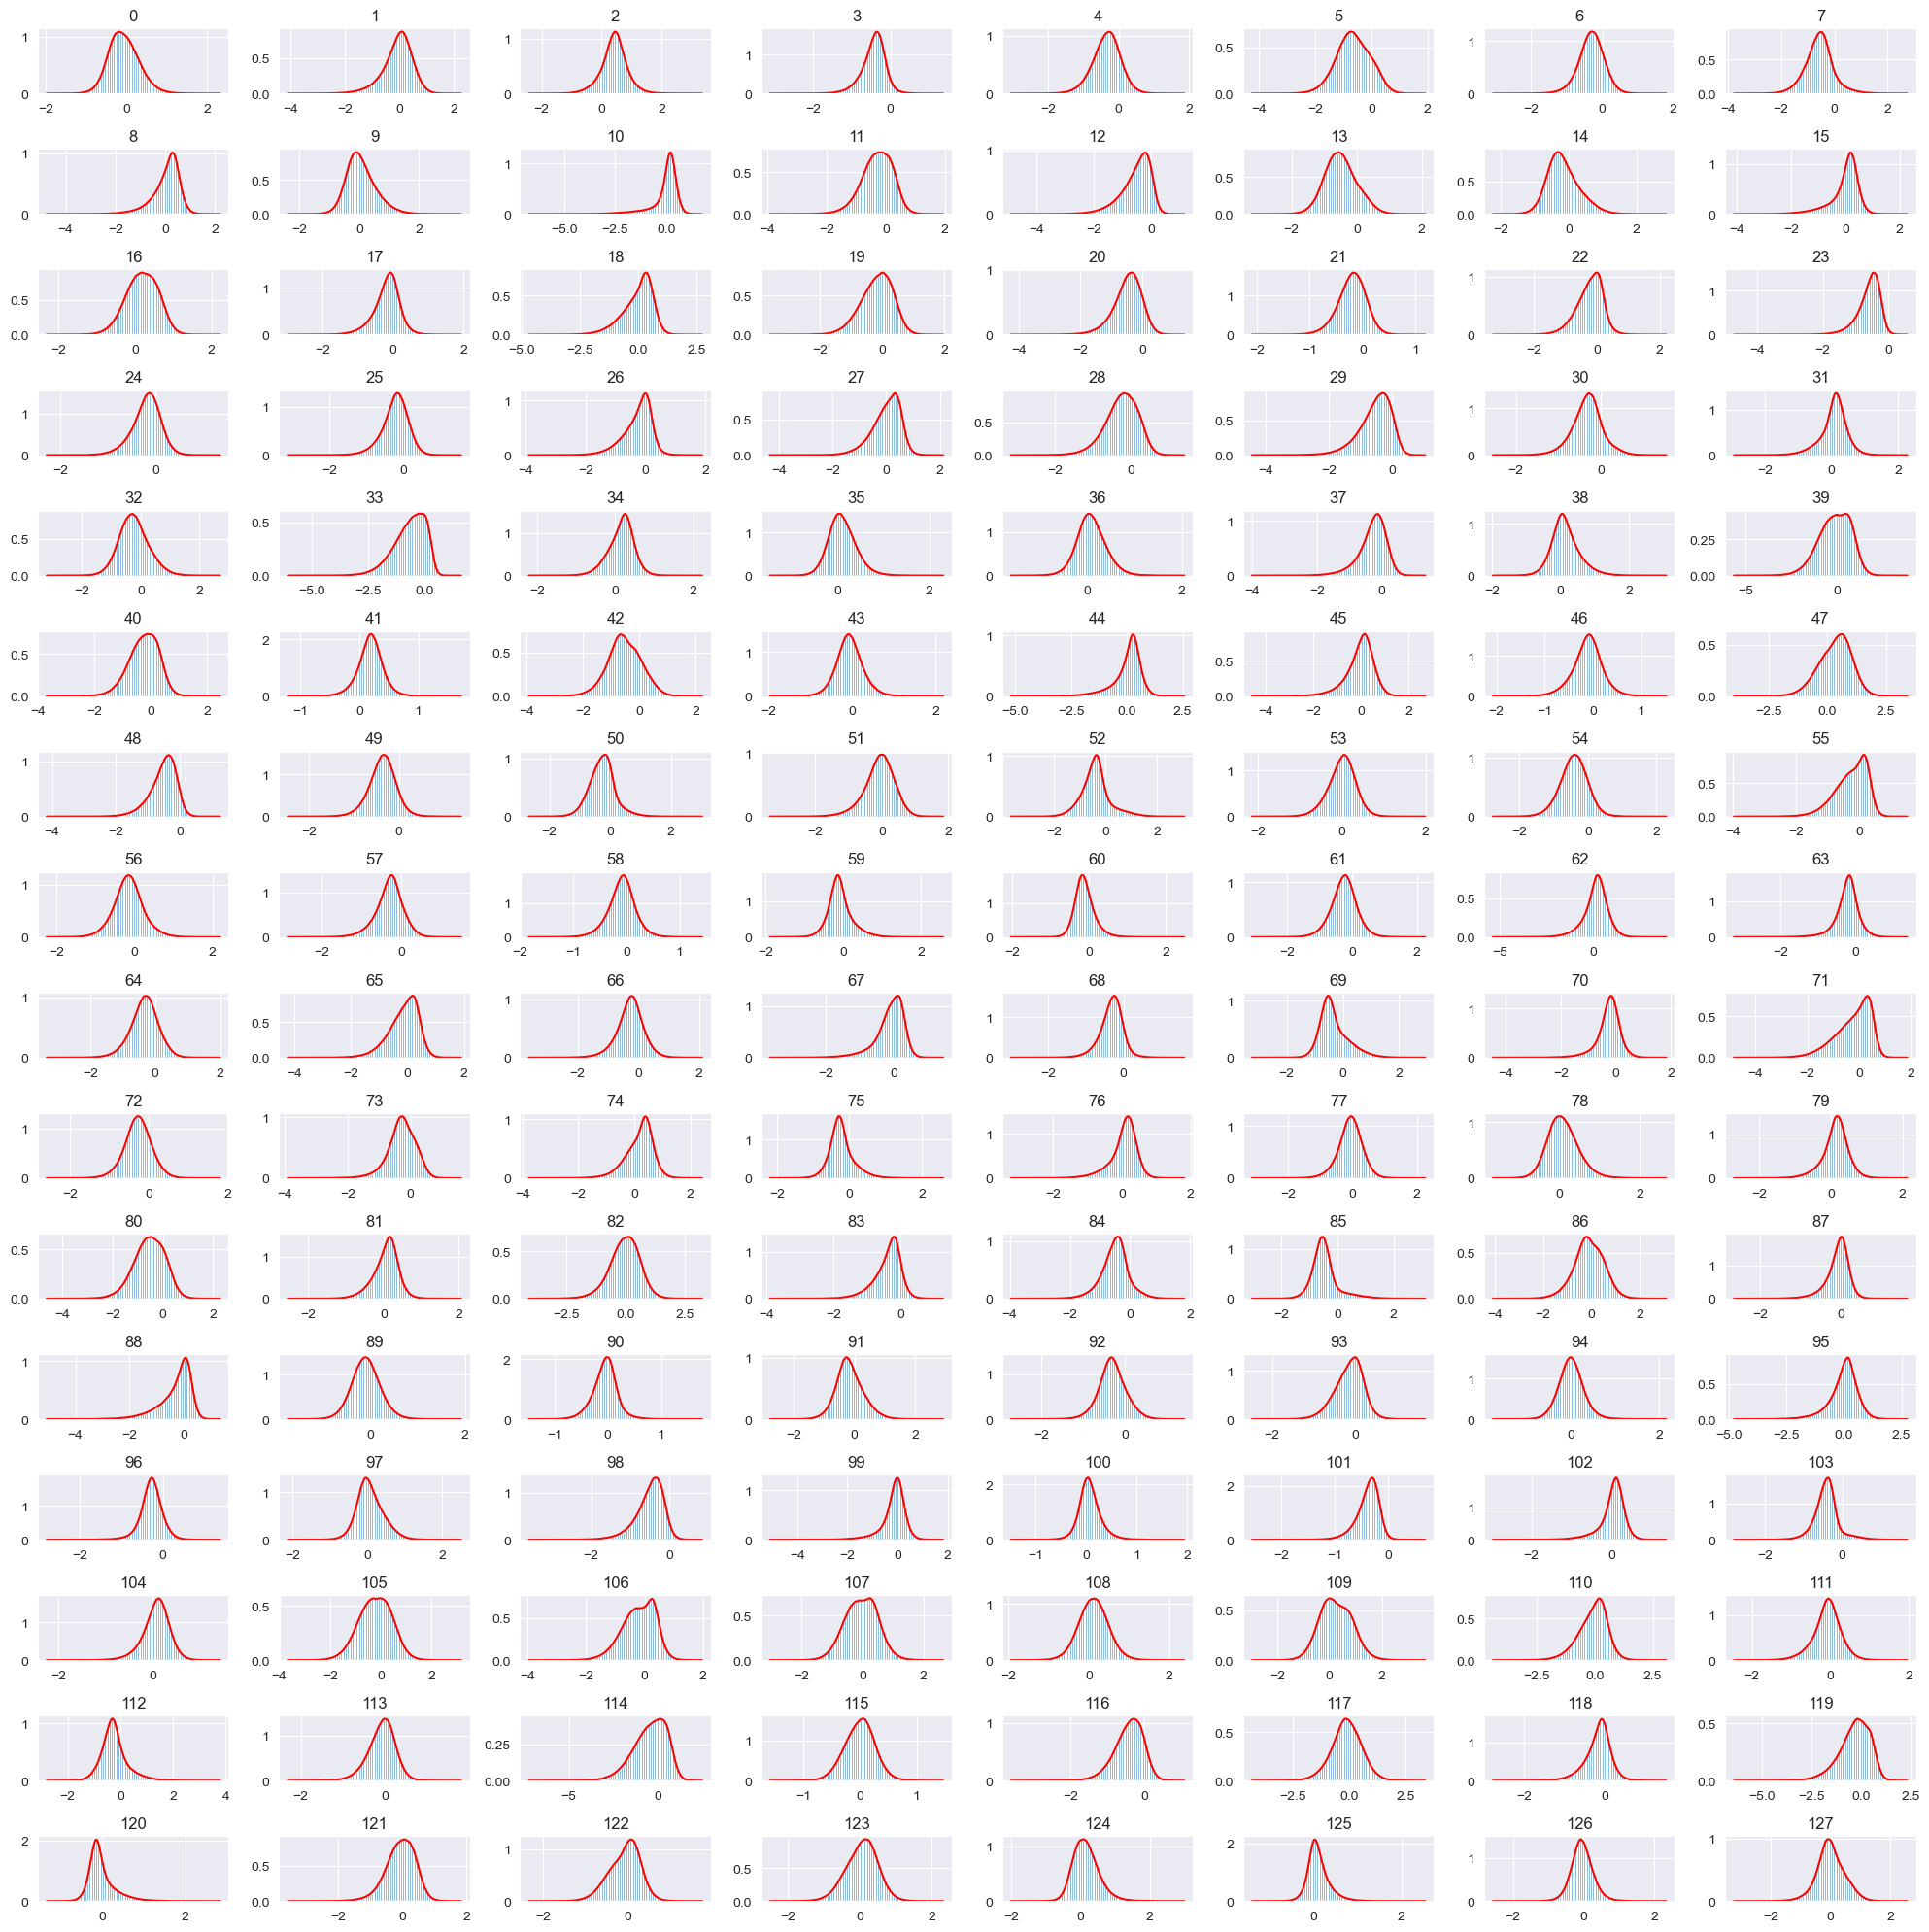

In [71]:
kde_fits = plot_histograms(pion_embeddings, 'pion', '4_pre_activation')

In [183]:
data = pion_embeddings[:, 0]
kde = gaussian_kde(data)


value = -0.2
likelihood = kde.pdf(value)

print(f"The likelihood of {value} is {likelihood}")



The likelihood of -0.2 is [1.07915343]


In [128]:
import pickle

def save_fits_to_disk(fits):
    for i in range(len(fits)):
        with open(f'../data/embeddings/layer4_pre_activation/fits/kde_fit_{i}.pkl', 'wb') as f:
            pickle.dump(fits[i], f)

def get_fits():
    fits = []
    for i in range(128):        
        _fit = gaussian_kde(pion_embeddings[:, i])
        fits.append(_fit)        
    return fits 

def load_fit_from_disk(i):
    with open(f'../data/embeddings/layer4_pre_activation/fits/kde_fit_{i}.pkl', 'rb') as f:
        fit = pickle.load(f)
    return fit


In [127]:
kde_fits = get_fits()
save_fits_to_disk(kde_fits)


In [159]:
# test a random embedding for a random input
import pandas as pd

def likelihood_dataframe(embedding):
    # Create a list of dictionaries
    data = [{'neuron': neuron, 'value': embedding[0, neuron], 'likelihood': kde_fits[neuron].pdf(embedding[0, neuron])} for neuron in range(len(embedding[0]))]

    # Convert the list to a DataFrame
    return pd.DataFrame(data)    

In [160]:
df = likelihood_dataframe(embedding_output)
df

,neuron,value,likelihood
0,0,0.056836,[0.9574096047230842]
1,1,-0.382492,[0.5109477596033883]
2,2,1.049715,[0.24674425974698513]
3,3,-0.439885,[1.4390288669013447]
4,4,-0.381915,[1.0216104642023227]
...,...,...,...
123,123,-0.884343,[0.0984473758283905]
124,124,0.008114,[1.1144646701125336]
125,125,-0.213256,[0.6025215213908393]
126,126,-0.683635,[0.12186027628495977]


In [161]:
def total_uncertainty(likelihoods):
    return likelihoods.mean()
    
print(f"Total Uncertainty: {total_uncertainty(df['likelihood'])} (average likelihood)")

Total Uncertainty: [0.63860107] (average likelihood)


In [164]:
for i in range(10):
    embedding_output2 = new_model.predict(np.random.rand(1, 3))
    df2 = likelihood_dataframe(embedding_output2)
    print(f"Total Uncertainty: {total_uncertainty(df2['likelihood'])} (average likelihood)")

1/1 [==============================] - 0s 16ms/step
Total Uncertainty: [0.75190978] (average likelihood)
1/1 [==============================] - 0s 0s/step
Total Uncertainty: [0.63635608] (average likelihood)
1/1 [==============================] - 0s 16ms/step
Total Uncertainty: [0.58357927] (average likelihood)
1/1 [==============================] - 0s 16ms/step
Total Uncertainty: [0.97765947] (average likelihood)
1/1 [==============================] - 0s 16ms/step
Total Uncertainty: [0.78966891] (average likelihood)
1/1 [==============================] - 0s 16ms/step
Total Uncertainty: [0.58816024] (average likelihood)
1/1 [==============================] - 0s 16ms/step
Total Uncertainty: [0.93562174] (average likelihood)
1/1 [==============================] - 0s 16ms/step
Total Uncertainty: [0.71849206] (average likelihood)
1/1 [==============================] - 0s 16ms/step
Total Uncertainty: [0.50840562] (average likelihood)
1/1 [==============================] - 0s 16ms/step
Total

Total Uncertainty: [0.7168088] (average likelihood)


# References

1. [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf)
2. [Keras documentation](https://keras.io/api/)
3. [StackOverflow](https://stackoverflow.com/)